# Docker&jupyterの起動
###  jupyter入ってない方用です
```docker run -it --rm -p 8888:8888 jupyter/datascience-notebook
http://localhost:8888/?token=xxxxxxxxxxxxxxxxxxxxx
```

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# データのダウンロード
### データセットはPandas経由で取得したNASDAQのFacebookのデータです

In [2]:
!pip install pandas_datareader

    100% |████████████████████████████████| 81kB 345kB/s ta 0:00:01
  Running setup.py bdist_wheel for requests-file ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/3e/34/3a/c2e634ca7b545510c1b3b7d94dea084e5fdb5f33558f3c3a81
  Running setup.py bdist_wheel for requests-ftp ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/fb/0d/1026eb562c34a4982dc9d39c9c582a734eefe7f0455f711deb
Successfully built requests-file requests-ftp


In [3]:
from pandas_datareader.data import DataReader
from datetime import datetime

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
fb = DataReader('FB', 'yahoo', start, end)

fb.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-09-29,129.179993,129.289993,127.550003,128.089996,128.089996,14532200
2016-09-30,128.029999,128.589996,127.449997,128.270004,128.270004,18402900
2016-10-03,128.380005,129.089996,127.800003,128.770004,128.770004,13156900
2016-10-04,129.169998,129.279999,127.550003,128.190002,128.190002,14307500
2016-10-05,128.250000,128.800003,127.830002,128.470001,128.470001,12386800


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


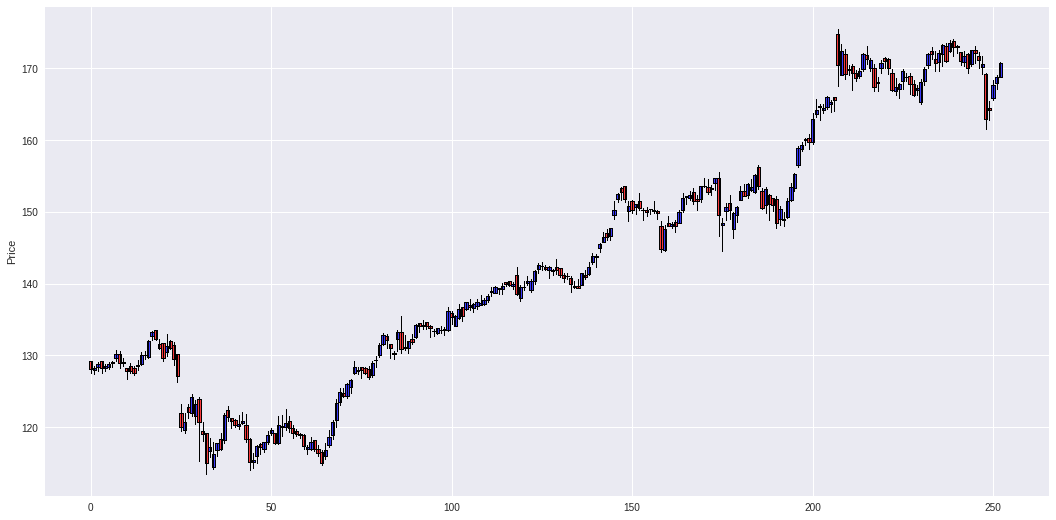

In [4]:
from matplotlib.finance import candlestick2_ohlc

# ローソクだけをプロット
fig = plt.figure(figsize=(18, 9))
ax = plt.subplot(1, 1, 1)

# candlestick2を使って描画
candlestick2_ohlc(ax, fb["Open"], fb["High"], fb["Low"], fb["Close"], width=0.9, colorup="b", colordown="r")

# 軸メモリやラベルを整える
ax.set_ylabel("Price")
plt.show()

# Prophetによる時系列予測

In [5]:
!pip install pystan
!pip install fbprophet

    100% |████████████████████████████████| 52.9MB 12kB/s eta 0:00:013 0% |▎                               | 522kB 1.3MB/s eta 0:00:40    1% |▌                               | 829kB 1.6MB/s eta 0:00:33    4% |█▍                              | 2.3MB 399kB/s eta 0:02:07    5% |█▊                              | 2.9MB 646kB/s eta 0:01:18    8% |██▉                             | 4.6MB 853kB/s eta 0:00:57    9% |███                             | 5.0MB 776kB/s eta 0:01:02    9% |███                             | 5.1MB 749kB/s eta 0:01:04    17% |█████▌                          | 9.0MB 562kB/s eta 0:01:18    19% |██████                          | 10.1MB 710kB/s eta 0:01:01    21% |██████▉                         | 11.2MB 909kB/s eta 0:00:46    23% |███████▋                        | 12.5MB 498kB/s eta 0:01:21    25% |████████                        | 13.3MB 311kB/s eta 0:02:07    25% |████████▏                       | 13.5MB 359kB/s eta 0:01:50    32% |██████████▍                     | 17.2MB 9

In [6]:
from fbprophet import Prophet

In [7]:
#read dataset
df = fb
df['y'] = df['Close']
df.reset_index(level='Date', inplace=True)
df = df.rename(columns = {'Date':'ds'})

In [8]:
#split dataset for train-test
df = df.sort_values(by='ds')
df_test = df.tail(30)
df_train = df.head(df.ds.count() -30)

In [9]:
#prediction
m = Prophet()
m.fit(df_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=30)

In [11]:
forecast = m.predict(future)
verification = pd.merge(df_test, forecast[['ds', 'yhat']].tail(30), on= 'ds')

verification['diff'] = abs(1-verification.yhat/verification.y)

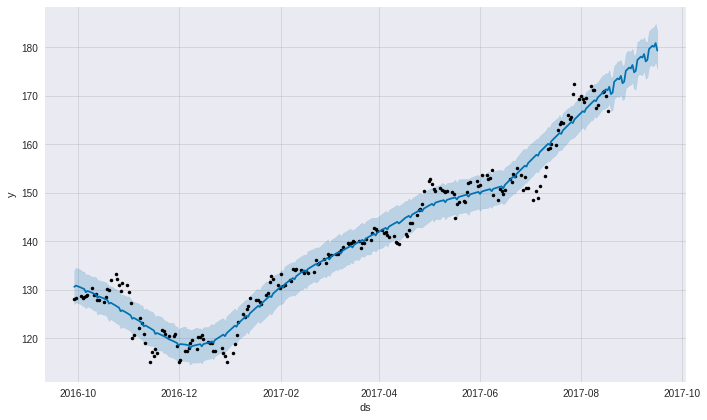

In [12]:
m.plot(forecast)
plt.show()

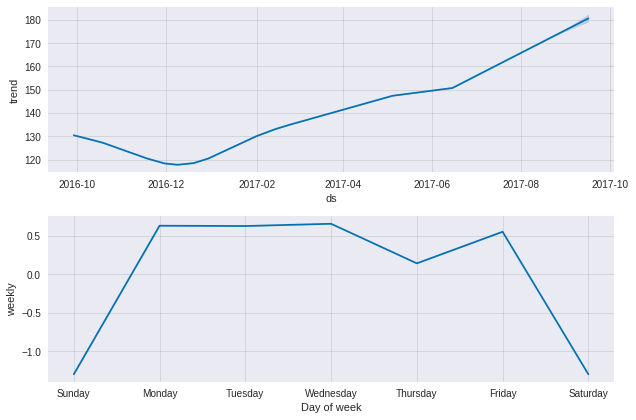

In [13]:
# トレンドと曜日成分の寄与度
m.plot_components(forecast)
plt.show()

difference
0     0.026438
1     0.030386
2     0.020956
3     0.028662
4     0.033473
5     0.046684
6     0.047157
7     0.043996
8     0.034569
9     0.021127
10    0.025072
11    0.040838
12    0.034589
13    0.026797
14    0.044641
15    0.035233
16    0.040358
17    0.041842
18    0.053463
19    0.053541
Name: diff, dtype: float64


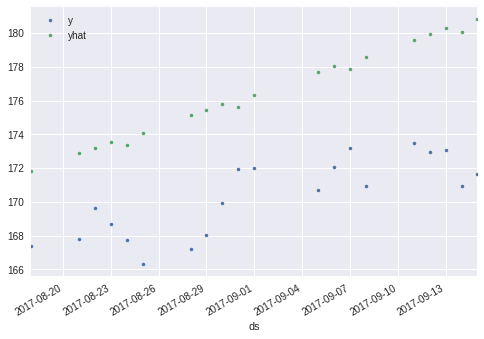

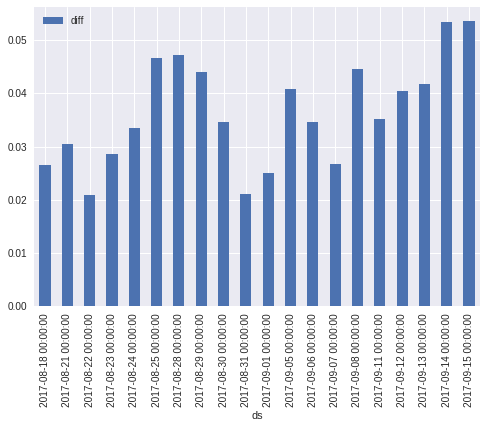

In [14]:
# 直近30日を予測してみた
print('difference')
print(verification['diff'])

verification.plot(x= 'ds', y= ['y','yhat'], style='.')
verification.plot(x= 'ds', y= 'diff', kind='bar')
plt.show()